# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:

![Christopher Search](./readonly/small_project.png)

If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):

![Mark Search](./readonly/large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

In [1]:
import zipfile as zf


from PIL import Image
from PIL import ImageDraw, ImageFont
import pytesseract
import cv2 as cv
import numpy as np
import math

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

# the rest is up to you!

# The Solution #

### Load pages

In [2]:
def load_imgs_from_zip(path):
    ''' Load all images archived in zip in given path.

    :param path: A string path to the ZIP file
    :return page_imgs: A dictionary of opened images
    '''
    with zf.ZipFile(path) as zipF:
        page_imgs = {page: Image.open(zipF.open(page)) for page in zipF.namelist()}
    return page_imgs

### Find Images with given text

In [3]:
def checkIfTextInImg(text, img):
    return (text in pytesseract.image_to_string(img))

def get_imgs_with_text(text, path):
    page_imgs = load_imgs_from_zip(path)
    return {imgName: page_imgs[imgName] for imgName in page_imgs if checkIfTextInImg(text, page_imgs[imgName])}


### Get faces from selected pages

In [4]:
def show_rects(faces, pil_img):
    # Set our drawing context
    drawing=ImageDraw.Draw(pil_img)
    # And plot all of the rectangles in faces
    for x,y,w,h in faces:
        drawing.rectangle((x,y,x+w,y+h), outline="red")
    display(pil_img)

def getFaceImgs(faces, page_img):
    ''' Gets faces' images from single page

    @param faces: list with face areas location [top, left, height, widthb]
    @param page_img: PIL.Image object, a page to get faces from
    @return: list of face imgs, PIL.Image objects
    '''
    return [page_img.crop((x,y,x+w, y+h)) for x,y,w,h in faces]

def processPages(pages):
    ''' Gets faces' images from single page

    @param faces: list with face areas location [top, left, height, widthb]
    @param page_img: PIL.Image object, a page to get faces from
    @return: dictionary {page_name: list of faces}
    '''
    pageFaces = {}
    for pageImg in pages:
        cv_img = cv.cvtColor(np.array(pages[pageImg]), cv.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(cv_img, 1.35)
        pageFaces[pageImg] = getFaceImgs(faces, pages[pageImg].copy())
    return pageFaces

# print(processPages(imgs_with_text))


In [5]:
def resize_img(img, max_width):
    ''' Resizes image if its width is bigger than max_width

    @param img: PIL image
    @param max_width: max width of the modified image
    @return: resized image
    '''

    if img.width > max_width:
        resize_ratio = max_width / img.width
        new_size = (max_width, int(img.height * resize_ratio))
        processed_img = (img.copy().resize( new_size, Image.LANCZOS))
    else:
        processed_img = img
    return processed_img


def resize_imgs(pageFaces, max_width):
    ''' Resizes all retrieved faces if their width is bigger than max_width

    @param img: PIL image
    @param max_width: max width of the modified image
    @return: list with resized images
    '''
    for page in pageFaces:
        pageFaces[page] = [resize_img(faceImg, max_width) for faceImg in pageFaces[page]]
    return pageFaces

## Create a contact sheet

In [6]:

def createPageContactSheet(faceImgs, face_img_width, face_img_height, img_columns):
    ''' :return: A page contact sheet including all found faces on the single page.
    '''
    img_rows = math.ceil(len(faceImgs) / img_columns)
    first_image = faceImgs[0]
    page_contact_sheet = Image.new(first_image.mode, (face_img_width*img_columns, face_img_height*img_rows))
    x=0
    y=0

    for img in faceImgs:
        page_contact_sheet.paste(img, (x, y) )
        if x+face_img_width >= page_contact_sheet.width:
            x=0
            y=y+face_img_height
        else:
            x=x+face_img_width

    return page_contact_sheet


def getPageContactSheets(pageFaces, face_img_width, face_img_height, img_columns):
    ''' :return: tuple with final contact sheet including all page contact sheets and total height of all contact sheets in pixels.
    '''
    pageContactSheets = {}
    total_height = 0
    for page in pageFaces:
        pageResult = {}
        if len(pageFaces[page]):
            pageResult['result'] = 'Results found in file {}'.format(page)
            pageResult['contactSheet'] = createPageContactSheet(pageFaces[page], face_img_width, face_img_height, img_columns)
            total_height += pageResult['contactSheet'].height + 30  # height + one line of text
            pageContactSheets[page] = pageResult
        else:
            pageResult['result'] = '''Results found in file {}\nBut there were no faces in that file!'''.format(page)
            total_height += 60  # two lines of text
            pageContactSheets[page] = pageResult
    
    return (pageContactSheets, total_height)


def displayContactSheet(word, zip):
    imgs_with_text = get_imgs_with_text(word, zip)

    max_width = 100
    pageFaces = processPages(imgs_with_text)
    pageFaces = resize_imgs(pageFaces, max_width)

    filteredPageFaces = {}
    for page in pageFaces:
        filteredPage = []
        for faceImg in pageFaces[page]:
            face_cv_img = cv.cvtColor(np.array(faceImg), cv.COLOR_RGB2GRAY)
            faceCheck = face_cascade.detectMultiScale(face_cv_img)
            if len(faceCheck) != 0:
                filteredPage.append(faceImg)
            # display(faceImg)
        filteredPageFaces[page] = filteredPage

    face_img_width  = 100
    face_img_height = 100
    img_columns = 5
    total_width = face_img_width * img_columns
    pageContactSheets, total_height = getPageContactSheets(filteredPageFaces, face_img_width, face_img_height, img_columns)

    final_contact_sheet = Image.new('RGB', (total_width+20, total_height+40), color=(255,255,255))
    x=10
    y=10
    font = ImageFont.truetype("calibri.ttf", 18)

    for page in pageContactSheets:
        if 'contactSheet' in pageContactSheets[page]:
            img = pageContactSheets[page]['contactSheet']
            caption = pageContactSheets[page]['result']
            # get a drawing context
            d = ImageDraw.Draw(final_contact_sheet)
            # draw multiline text
            d.text((x,y), caption, font=font, fill=(0, 0, 0))
            y = y + 30
            final_contact_sheet.paste(img, (x, y) )

            y = y+img.height+10
        else:
            caption = pageContactSheets[page]['result']
            d = ImageDraw.Draw(final_contact_sheet)
            d.multiline_text((x,y), caption, font=font, fill=(0, 0, 0))
            y = y + 38


    display(final_contact_sheet)




## Generate final output

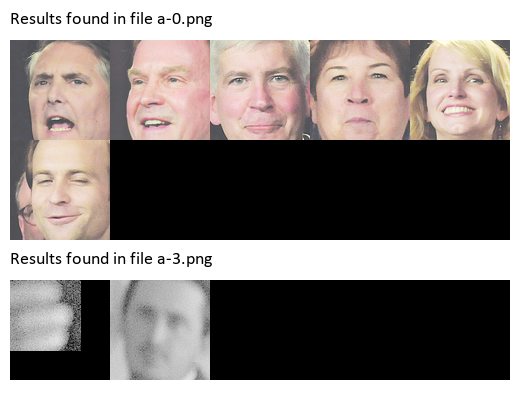

In [7]:
displayContactSheet('Christopher', 'readonly/small_img.zip')

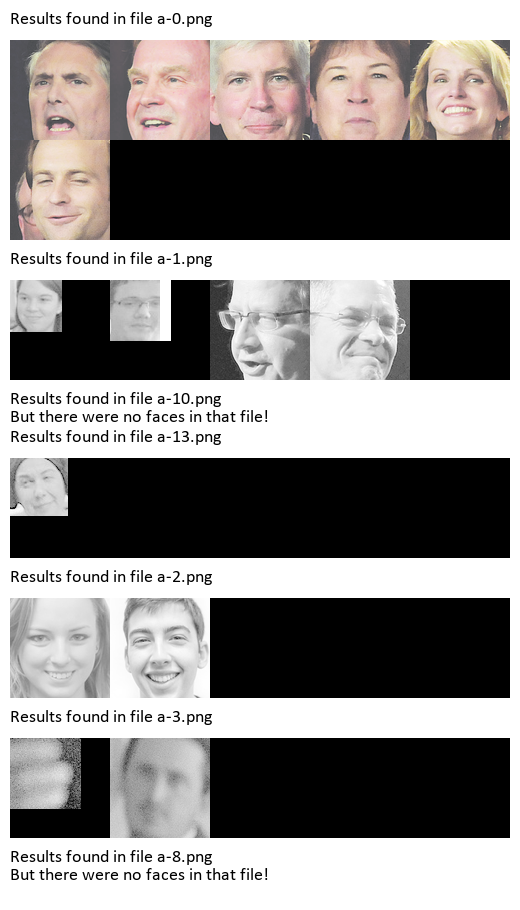

In [8]:
displayContactSheet('Mark', 'readonly/images.zip')